# 1. Imports 

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# constants
path = 'C:/Users/monte/Documents/Memoria/src'
#path = 'C:/Users/asus/Documents/2023_2/Memoria/src'

# Ostar
O_df = pd.read_csv(path+'/Data/o_spectral_lines.csv')
O_df = O_df.drop('Unnamed: 0',axis=1)
# Bstar
B_df = pd.read_csv(path+'/Data/b_spectral_lines.csv')
B_df = B_df.drop('Unnamed: 0',axis=1)

# 2. Data

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

target = ['temperature','g','v']


X = B_df.drop(target,axis = 1)
Y = B_df[target]

y_scaler = StandardScaler()

x_train, x_val, y_train, y_val = train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=42)
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, train_size=0.75, test_size=0.25, random_state=42)

y_scaler = y_scaler.fit(y_train)
y_train = y_scaler.transform(y_train)
y_val = y_scaler.transform(y_val)
y_test = y_scaler.transform(y_test)

In [4]:
B_df.head()

,4440.000,4440.100,4440.200,4440.300,4440.400,4440.500,4440.600,4440.700,4440.800,4440.900,...,4509.400,4509.500,4509.600,4509.700,4509.800,4509.900,4510.000,temperature,g,v
0,0.9995,0.9997,0.9998,0.9998,0.9998,0.9996,0.9991,0.9987,0.9984,0.9981,...,0.9999,0.9999,0.9999,0.9999,0.9999,0.9999,0.9999,15000.0,1.75,102.0
1,0.9995,0.9997,0.9998,0.9998,0.9997,0.9994,0.9990,0.9986,0.9983,0.9980,...,0.9999,0.9999,0.9999,0.9999,0.9999,0.9999,0.9999,15000.0,1.75,105.0
2,0.9995,0.9997,0.9998,0.9998,0.9997,0.9992,0.9988,0.9985,0.9982,0.9980,...,0.9999,0.9999,0.9999,0.9999,0.9999,0.9999,0.9999,15000.0,1.75,108.0
3,0.9995,0.9997,0.9998,0.9997,0.9995,0.9991,0.9987,0.9984,0.9982,0.9980,...,0.9999,0.9999,0.9999,0.9999,0.9999,0.9999,0.9999,15000.0,1.75,111.0
4,0.9995,0.9997,0.9998,0.9997,0.9993,0.9989,0.9986,0.9984,0.9982,0.9980,...,0.9999,0.9999,0.9999,0.9999,0.9999,0.9999,0.9999,15000.0,1.75,114.0


# 3. NN Training

In [5]:
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras import layers 

#input_shape = (4, 10, 128) = (batch_size, steps, vectorLength) = (batchsize, rotaciones, frecuencias)

normalize = layers.Normalization()

normalize.adapt(x_train)

input_shape = (x_train.shape[1],1)

def generate_model(): 
  return tf.keras.Sequential([
  keras.Input(shape=(input_shape)),
  normalize,
  layers.Conv1D(32,padding="same",kernel_size=3, activation='relu'),
  layers.Conv1D(32,padding="same",kernel_size=3, activation='relu'),
  layers.Conv1D(32,padding="same",kernel_size=3, activation='relu'),
  layers.MaxPooling1D(pool_size=3, padding='same'),
  layers.Conv1D(64,padding="same",kernel_size=2, activation='relu'),
  layers.Conv1D(64,padding="same",kernel_size=2, activation='relu'),
  layers.Conv1D(64,padding="same",kernel_size=2, activation='relu'),
  layers.MaxPooling1D(pool_size=2, padding='same'),
  layers.Conv1D(128,padding="same",kernel_size=2, activation='relu'),
  layers.Conv1D(128,padding="same",kernel_size=2, activation='relu'),
  layers.Conv1D(128,padding="same",kernel_size=2, activation='relu'),
  layers.MaxPooling1D(pool_size=2, padding='same'),
  layers.GlobalAveragePooling1D(),
  
  layers.Dense(128, activation='relu'),
  layers.Dense(3, activation='linear')
])

In [6]:
model = generate_model()
model = tf.keras.Model(inputs=model.input, outputs=model.output) 
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 701, 1)]          0         
                                                                 
 normalization (Normalizatio  (None, 701, 701)         1403      
 n)                                                              
                                                                 
 conv1d (Conv1D)             (None, 701, 32)           67328     
                                                                 
 conv1d_1 (Conv1D)           (None, 701, 32)           3104      
                                                                 
 conv1d_2 (Conv1D)           (None, 701, 32)           3104      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 234, 32)          0         
 )                                                           

In [7]:
model.compile(loss = ['MSE'],
                           optimizer = tf.optimizers.Adam(),
                           metrics=['MAE'])

# model.compile(loss='MAE',optimizer=optimizer,metrics=['MSE'])
#history = simple_model.fit(x=x_train, y=y_train, validation_data=(x_val,y_val), epochs=20)

history = model.fit(x=x_train, y=y_train,validation_data=(x_val,y_val), epochs=10)

Epoch 1/10
459/459 [==============================] - 30s 40ms/step - loss: 0.2631 - MAE: 0.3652 - val_loss: 0.1304 - val_MAE: 0.2660
Epoch 2/10
459/459 [==============================] - 16s 35ms/step - loss: 0.0748 - MAE: 0.1917 - val_loss: 0.0448 - val_MAE: 0.1473
Epoch 3/10
459/459 [==============================] - 16s 35ms/step - loss: 0.0460 - MAE: 0.1487 - val_loss: 0.0241 - val_MAE: 0.1040
Epoch 4/10
459/459 [==============================] - 16s 35ms/step - loss: 0.0234 - MAE: 0.1119 - val_loss: 0.0153 - val_MAE: 0.0886
Epoch 5/10
459/459 [==============================] - 16s 35ms/step - loss: 0.0155 - MAE: 0.0912 - val_loss: 0.0165 - val_MAE: 0.0915
Epoch 6/10
459/459 [==============================] - 16s 35ms/step - loss: 0.0152 - MAE: 0.0892 - val_loss: 0.0098 - val_MAE: 0.0693
Epoch 7/10
459/459 [==============================] - 16s 35ms/step - loss: 0.0104 - MAE: 0.0756 - val_loss: 0.0095 - val_MAE: 0.0760
Epoch 8/10
459/459 [==============================] - 16s 35ms

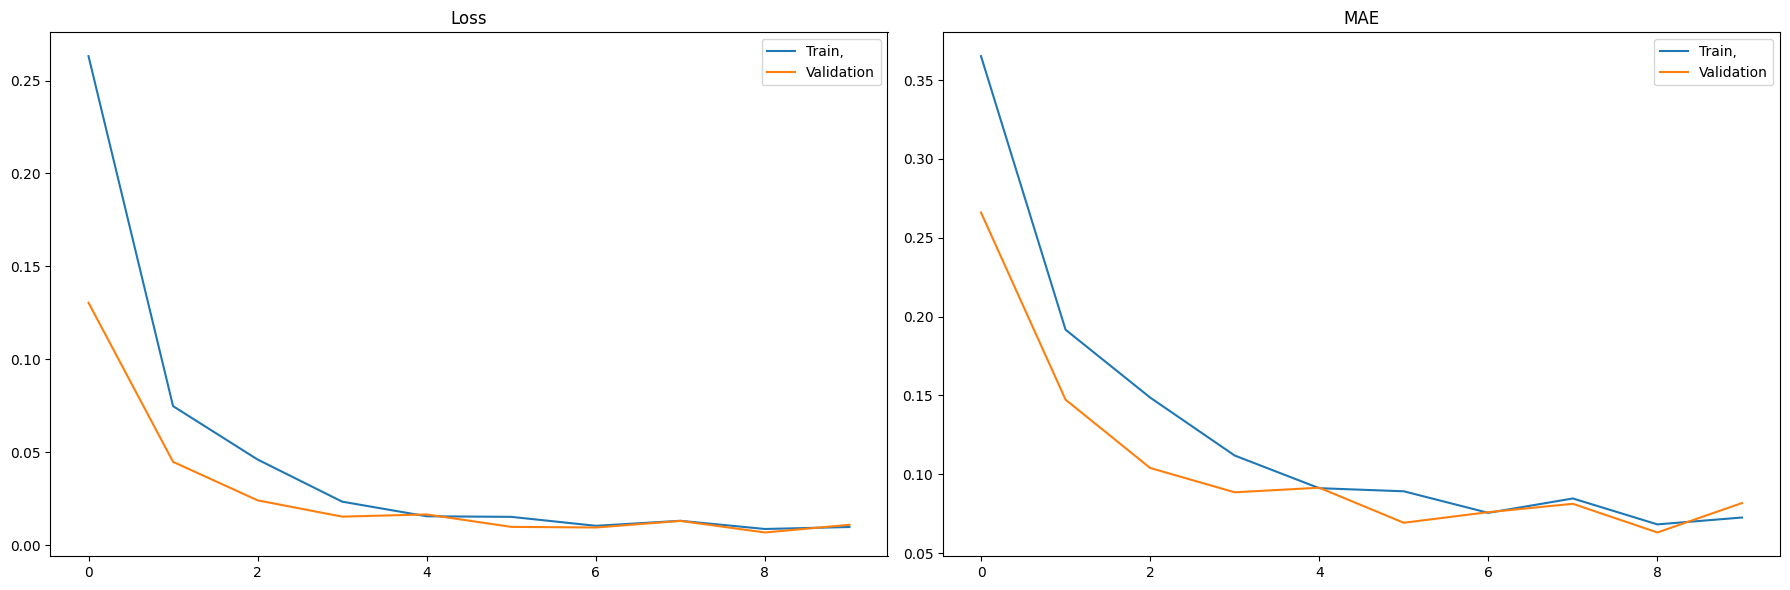

In [8]:
fig, axis = plt.subplots(1, 2, figsize=(18,6))
# trendlines
axis[0].plot(history.history['loss'], label='train t_out_loss')
axis[1].plot(history.history['MAE'], label='val  t_out_loss')
axis[0].plot(history.history['val_loss'], label='train t_out_accuracy')
axis[1].plot(history.history['val_MAE'], label='val t_out_accuracy')

# titles
axis[0].set_title("Loss")
axis[1].set_title("MAE")

# legends
axis[0].legend(['Train,','Validation'])
axis[1].legend(['Train,','Validation'])

plt.tight_layout()
plt.show()

In [9]:
predictions = y_scaler.inverse_transform(model.predict(x_val))

153/153 [==============================] - 2s 14ms/step


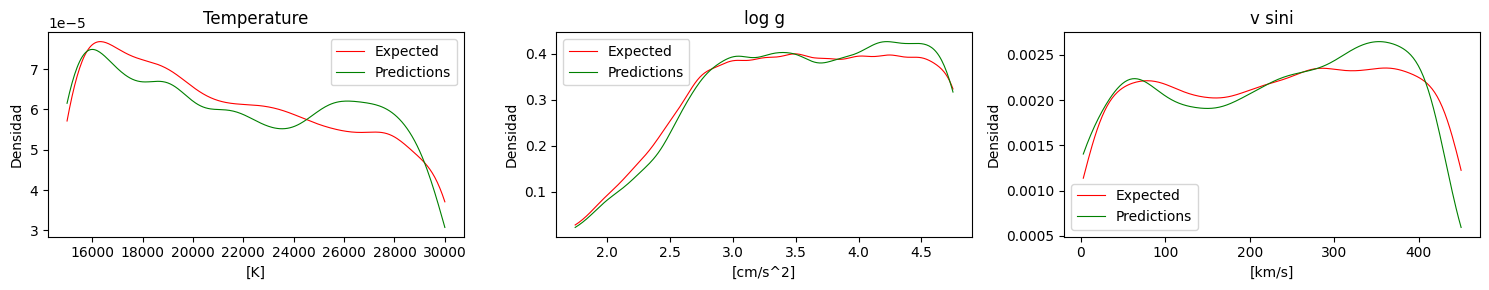

In [10]:
# Ref: https://stackoverflow.com/questions/60130503/plotting-bars-hist-and-pdf-line-via-kdeplot
import scipy.stats as st

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,3))

for i, featureName in enumerate(target):
	#predictions kernel
	x_space = np.linspace(Y[featureName].min(), Y[featureName].max(), 301)
	prediction_y = predictions[:,i] # your data goes here
	prediction_kde = st.gaussian_kde(prediction_y)
	prediction_h = prediction_kde.pdf(x_space)
 
	#expected values kernel
	expected_y = y_scaler.inverse_transform(y_val)[:,i]
	expected_kde = st.gaussian_kde(expected_y)
	expected_h = expected_kde.pdf(x_space)
 
	axes[i].plot(x_space, expected_h,color='red',alpha=1,linewidth=0.8,label='Expected')
	axes[i].plot(x_space, prediction_h,color='green',alpha=1,linewidth=0.8,label='Predictions')
	axes[i].set_title(target[i])
	measure = ['Temperature','log g', 'v sini']
	measure_unit = ['[K]', '[cm/s^2]', '[km/s]']
	axes[i].set_xlabel(measure_unit[i])
	axes[i].set_ylabel('Densidad')
	axes[i].set_title(measure[i])
	axes[i].legend()

plt.tight_layout()
plt.show()

# 4. Ensemble

In [11]:
from keras.optimizers import Adam
from keras.models import Model

NUM_MODELS = 100
models = [generate_model() for i in range(NUM_MODELS)]
history = []


for i, model in enumerate(models):
	optimizer = Adam()
	model.compile(loss='MAE',optimizer=optimizer)
	history.append(model.fit(x=x_train, y=y_train, epochs=10))

Epoch 1/10
459/459 [==============================] - 15s 30ms/step - loss: 0.3682
Epoch 2/10
459/459 [==============================] - 14s 30ms/step - loss: 0.1991
Epoch 3/10
459/459 [==============================] - 14s 30ms/step - loss: 0.1565
Epoch 4/10
459/459 [==============================] - 15s 32ms/step - loss: 0.1288
Epoch 5/10
459/459 [==============================] - 14s 31ms/step - loss: 0.1117
Epoch 6/10
459/459 [==============================] - 14s 31ms/step - loss: 0.0979
Epoch 7/10
459/459 [==============================] - 14s 30ms/step - loss: 0.0947
Epoch 8/10
459/459 [==============================] - 14s 30ms/step - loss: 0.0859
Epoch 9/10
459/459 [==============================] - 14s 30ms/step - loss: 0.0818
Epoch 10/10
459/459 [==============================] - 14s 30ms/step - loss: 0.0777
Epoch 1/10
459/459 [==============================] - 15s 30ms/step - loss: 0.3836
Epoch 2/10
459/459 [==============================] - 14s 30ms/step - loss: 0.2094
Epo

In [24]:
predictions = [y_scaler.inverse_transform(model.predict(x_test)) for model in models] # dim(predictions) = (num_models, num_rows, num_outputs)

153/153 [==============================] - 2s 14ms/step


In [13]:
# guardar predicciones por modelo
#for i,m in enumerate(predictions):
#    f = open('./predictions/m_'+str(i)+'.txt','w')
#    for row in m:
#        for p in row:
#            f.write(str(p)+' ')
#        f.write('\n')
#    f.close()

In [14]:
# leer predicciones por modelo
#NUM_MODELS = 1
#predictions = []
#for i in range(NUM_MODELS):
#  fp = open('predictions/m_'+str(i)+'.txt','r')
#  file = fp.readlines()
#  mPredictios = []
#  for line in file:
#    t, g, v = line.split()
#    mPredictios.append([float(t),float(g),float(v)])
#  predictions.append(mPredictios)
#predictions = np.array(predictions)

In [15]:
# leer modelos
#models = []
#for i in range(NUM_MODELS):
#  model = keras.models.load_model('models/m_'+str(i)+'.h5')
#  models.append(model)

In [25]:
weights = [model.evaluate(x_test, y_test) for model in models]
weights = [weight/sum(weights) for weight in weights]

ensemble_prediction = sum([predictions[i]*weights[i] for i in range(len(models))])
uncertainty = sum([(predictions[i]-ensemble_prediction)**2*weights[i] for i in range(len(models))])


153/153 [==============================] - 3s 16ms/step - loss: 0.0602


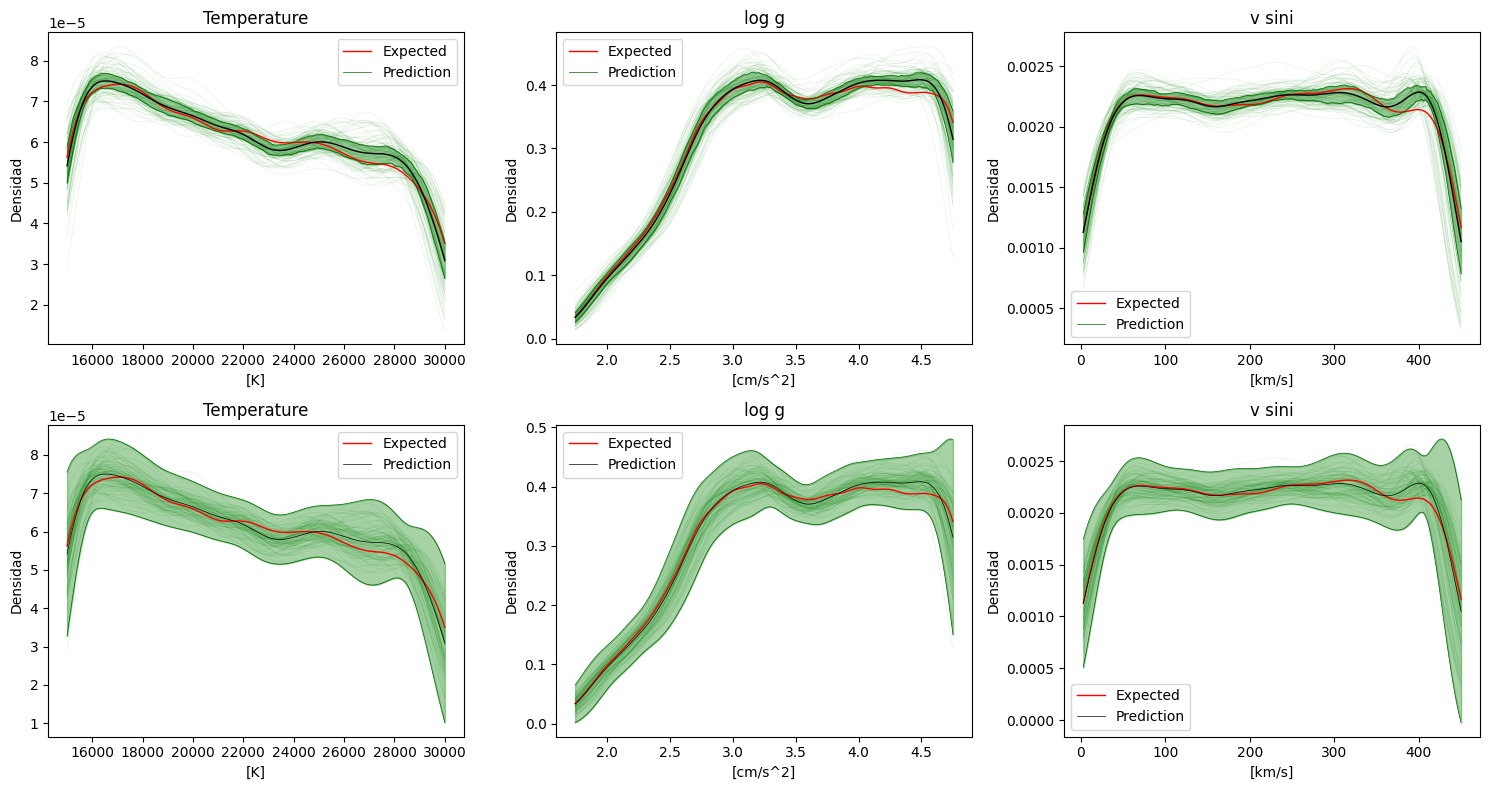

In [32]:
# Ref: https://stackoverflow.com/questions/60130503/plotting-bars-hist-and-pdf-line-via-kdeplot
import scipy.stats as st

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15,8))

for i, featureName in enumerate(target):
	x_space = np.linspace(Y[featureName].min(), Y[featureName].max(), 301)
	heights = []
	for j in range(NUM_MODELS):
		prediction_y = np.array(predictions)[j,:,i] # your data goes here
		prediction_kde = st.gaussian_kde(prediction_y)
		h = prediction_kde.pdf(x_space)
		heights.append(h)
		axes[0,i].plot(x_space, h,color='green',alpha=0.1,linewidth=0.5)
		axes[1,i].plot(x_space, h,color='green',alpha=0.1,linewidth=0.5)
  
	heights = np.array(heights)
 
	expected_y = y_scaler.inverse_transform(y_test)[:,i]
	expected_kde = st.gaussian_kde(expected_y)
	expected_h = expected_kde.pdf(x_space)
 
	q25 = np.quantile(heights,0.25,axis=0)
	q75 = np.quantile(heights,0.75,axis=0)
	
	axes[0,i].plot(x_space, expected_h,color='red',alpha=1,linewidth=1, label='Expected')
	axes[1,i].plot(x_space, expected_h,color='red',alpha=1,linewidth=1, label='Expected')
	
	#cuantiles
	axes[0,i].plot(x_space, np.mean(heights,axis=0),color='black',alpha=1,linewidth=1)
	axes[0,i].plot(x_space, q25,color='darkGreen',alpha=1,linewidth=0.5,label='Prediction')
	axes[0,i].plot(x_space, q75,color='darkGreen',alpha=1,linewidth=0.5)
	axes[0,i].fill_between(x_space, q25,q75, alpha=0.35, color='green')
	
	# 3 desviaciones estandar
	mu = np.mean(heights,axis=0)
	sigma = np.std(heights,axis=0)
	axes[1,i].plot(x_space, np.mean(heights,axis=0),color='black',alpha=1,linewidth=0.5,label='Prediction')
	axes[1,i].plot(x_space, mu-3*sigma,color='darkGreen',alpha=1,linewidth=0.5)
	axes[1,i].plot(x_space, mu+3*sigma,color='darkGreen',alpha=1,linewidth=0.5)
	axes[1,i].fill_between(x_space, mu-3*sigma,mu+3*sigma, alpha=0.35, color='green')
	
	measure = ['Temperature','log g', 'v sini']
	measure_unit = ['[K]', '[cm/s^2]', '[km/s]']
	axes[1,i].set_xlabel(measure_unit[i])
	axes[1,i].set_ylabel('Densidad')
	axes[1,i].legend()
	axes[1,i].set_title(measure[i])

	axes[0,i].set_xlabel(measure_unit[i])
	axes[0,i].set_ylabel('Densidad')
	axes[0,i].legend()
	axes[0,i].set_title(measure[i])

plt.tight_layout()
plt.show()

# Espectro real

In [18]:
import math
fileName = 'HD60606_2012-11-13_08-02-38_final_corr.txt'
f = open('../Data/RealSpectra/'+fileName)

data = f.readlines()
intensities = []
frequencies = []

for row in data:
	freq, intensity = row.split() 
	if float(freq) >= 4440.0 and float(freq) <= 4510.0:
		frequencies.append(float(freq))
		intensities.append(float(intensity))
    
#print(len(intensities))
f = len(frequencies)/83
for i in range(82,-1,-1):
	intensities.pop(math.floor(i*f))
	frequencies.pop(math.floor(i*f))


In [19]:
predictions = [model.predict([intensities]) for model in models]

1/1 [==============================] - 0s 335ms/step


In [20]:
import numpy as np
real_pred = np.mean(np.array(predictions),axis=0)

ensemble_prediction = sum([real_pred*weights[i] for i in range(len(models))])
uncertainty = sum([(real_pred-ensemble_prediction)**2*weights[i] for i in range(len(models))])


In [21]:
y_scaler.inverse_transform(ensemble_prediction)

array([[3.8344512e+04, 4.1815391e+00, 3.6670967e+01]], dtype=float32)